In [14]:
import networkx as nx
import numpy as np
import pickle
from random import randint

%matplotlib inline
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from tqdm.notebook import trange, tqdm
from time import time
from ipywidgets import interact, fixed
from scipy import optimize

import seaborn as sns
sns.set()

import os, sys
currentdir = os.path.dirname(os.path.realpath(__name__))
scriptsdir = os.path.dirname(currentdir)+'/scripts'
sys.path.append(scriptsdir)

from distances import dist_1d, dist_2d_lattice, dist_2d_spacial
from random_walks import simple_2d_random_walk, lazy_2d_random_walk
from generate_graph import Kleinberg_2d, small_world_2d, small_world_2d_new, sparse_lattice_graph
from analysis import get_path_forG, increase_walks_forG, get_new_start, get_mixing_time, get_prob_distribution, increase_prob_distribution, get_L1_norm_over_step_count, get_L1_norm

# Study of the total variance

In this section we analyze the total variance of the simulated probability to get to some nodes, using a lazy random walk, with the stationary probability of the small world graph.

\begin{equation}
d_i(t)=||P_i(x_t=y)-\pi(y)||_{TV}={1\over 2}||P_i(x_t=y)-\pi(y)||_1
\end{equation}
-$P_i(x_t=y)$ is the probability to get to some nodes y after t steps by starting at i node

-$\pi(y)$ is the stationary distribution, and therefore the stationary probability to get at y node

-$d_i(t)$ is the total variance after t steps starting at node i

The stationary distribution is
\begin{equation}
\pi(y)={\text{degree}(y)\over 2 *\text{number of nodes}}
\end{equation}

To simulate $P_i(x_t=y)$ we used this algorithm:

    1) choose a starting nodes i
    2) choose a fixed number of steps, called max_steps 
    3) choose a fixed number of different paths to perform a statistic, called max_walks
    4) perform an histogram for each steps containing the frequency of visits to each node for each path, and compute the L_1 norm with the stationary distribution

In this way we'll be able to compute the total variance after any choosen steps. The 3) step is the most important, since as we will see the total variance is bounded from below by this number 

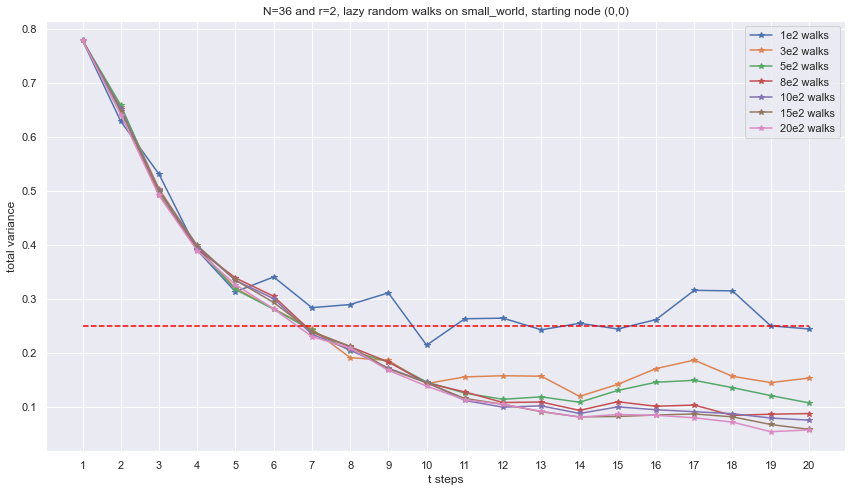

In [84]:
# Example code to construct the plot for a graph with 36 nodes


r=2
L=6
max_steps=40
max_walks=50*(L**2)
starting=(0,0)
#uploading the graph
pkl_file = open('Small_world_graphs/graph_L={}_r={}.pkl'.format(L,r), 'rb')
G = pickle.load(pkl_file)

#uploading the data
pkl_file = open('Small_world_L={}_r={}/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,r,L,max_steps,max_walks,starting), 'rb')
data = pickle.load(pkl_file)
norm_vector_list_parallel = []
for i in tqdm([1,3,5,8,10,15,20]):
    tic = time()
    norm_vector = get_L1_norm(G, L, data, max_steps=max_steps, max_walks=int(i*1e2))
    toc = time()
    time_i = toc-tic
    norm_vector_list_parallel.append((i, time_i, norm_vector))
# Plot
fig, ax1 = plt.subplots(figsize=(12,7))
#max_steps_plot=29
max_steps_plot=20
X=np.arange(1,max_steps_plot+1,1)
for i, time_i, norm_vector in norm_vector_list_parallel:
    ax1.plot(X,norm_vector[:max_steps_plot], "*-",label="{}e2 walks".format(i))
x=np.linspace(1,max_steps_plot,num=100)
y=np.linspace(0.25,0.25,num=100)
ax1.plot(x, y,'--', color='red')


ax1.set_title('N={} and r=2, lazy random walks on small_world, starting node (0,0)'.format(L**2))
ax1.set_xlabel('t steps')
ax1.set_ylabel('total variance')
X=np.arange(1,max_steps_plot+1,1)
ax1.set_xticks(X)
ax1.legend()
plt.tight_layout()
#plt.savefig(currentdir+'/Plots_new/'+'small_world_L={}_r={}_.png'.format(L,r), dpi=300)
plt.show()





for a small world graph with r=2


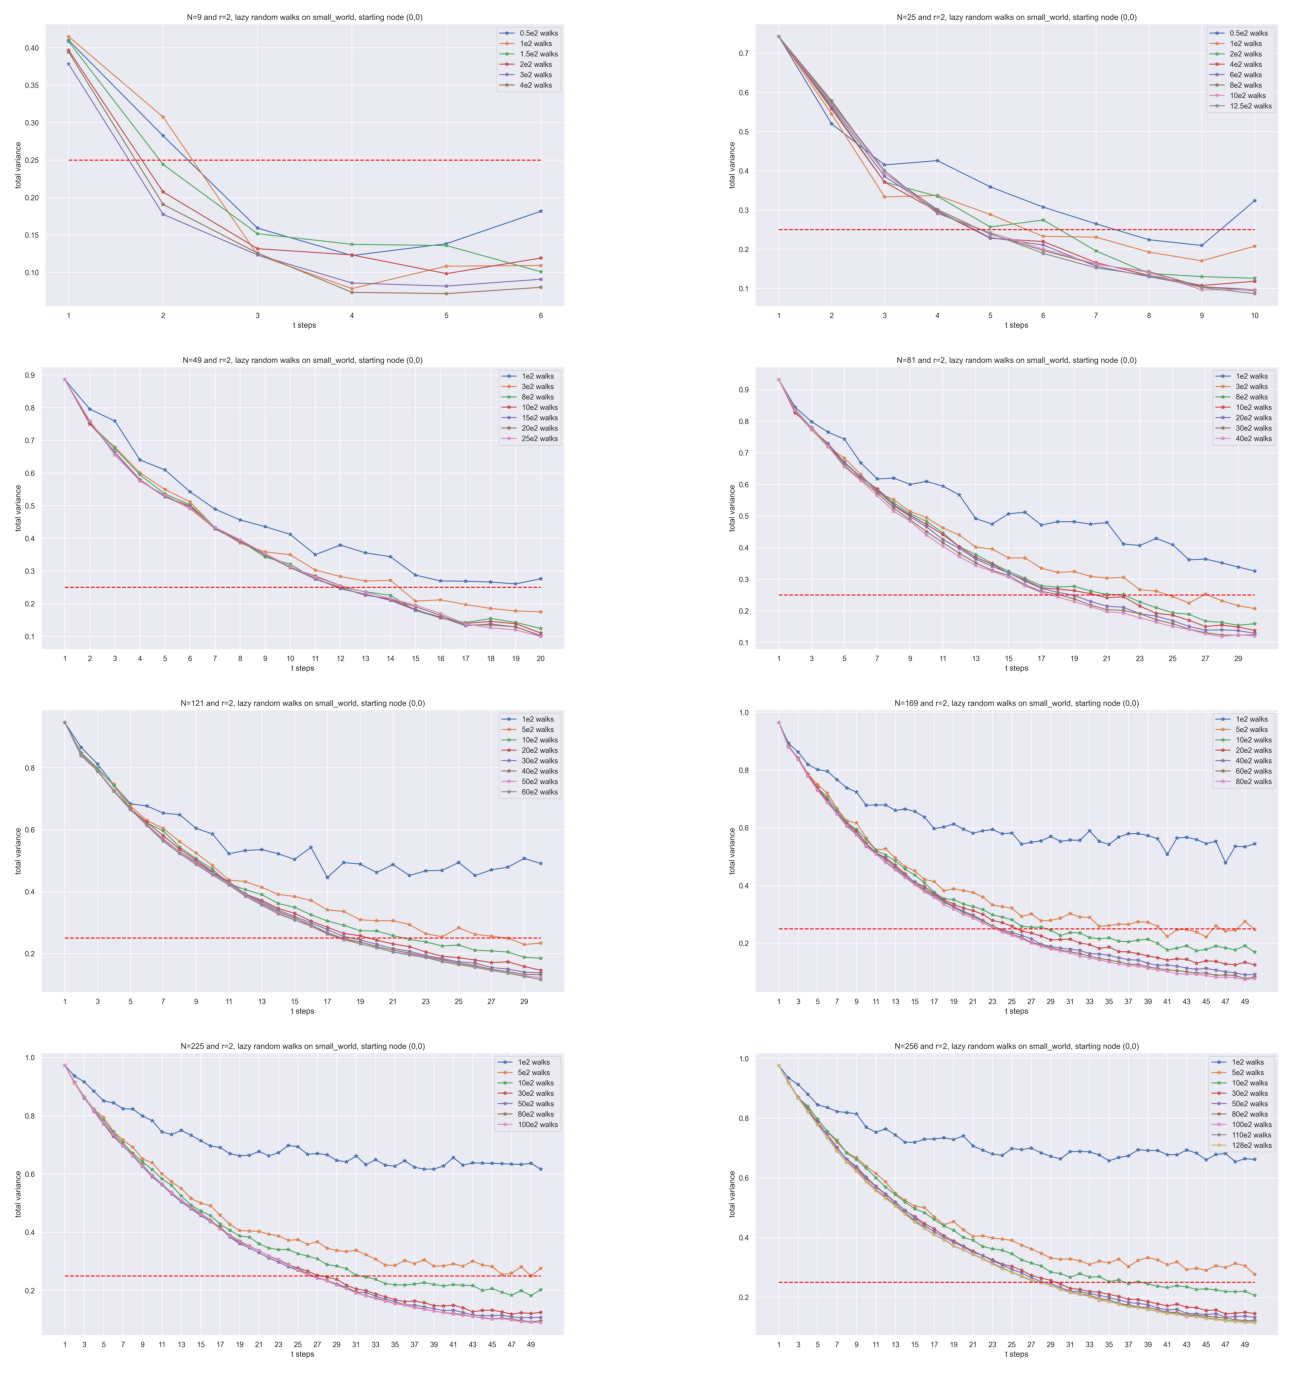

In [2]:
files=[]
for L in [3,5,7,9,11,13,15,16]:
    files.append("Plots_new/small_world_L={}_r=2_.png".format(L))

plt.figure(figsize=(20, 24))
print("for a small world graph with r=2")
for i, file_name in enumerate(files):
    plt.subplot(5, 2, i+1)
    plt.imshow(plt.imread(file_name))
    plt.axis('off')

plt.tight_layout()
plt.show()

From these plots we can see that the total variance is clearly bounded from below by the max_walks. Indeed the convergence with the stationary distribution in this approach is considered in the limit of max_walks tends to infinity (not in the steps tend to infinty as in the convergence theorem). 

Let's consider for example a huge number of walks for L=10 (100 number of nodes)

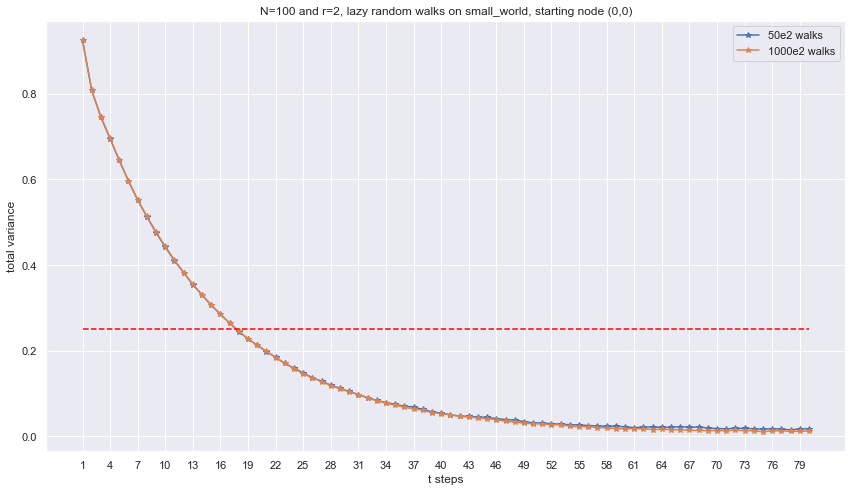

In [6]:
L=10
r=2
start=(0,0)
# load the graph
pkl_file = open('Small_world_graphs/graph_L={}_r={}.pkl'.format(L,r), 'rb')
G = pickle.load(pkl_file)
max_steps=80
max_walks=int(1e5)
paths=get_path_forG(G,L,max_steps=max_steps,max_walks=max_walks)
norm_vector_list_parallel = []
for i in [50,1000]:
    norm_vector = get_L1_norm(G, L, paths, max_steps=max_steps, max_walks=int(i*1e3))
    norm_vector_list_parallel.append((i,  norm_vector))
fig, ax1 = plt.subplots(figsize=(12,7))
#max_steps_plot=29
max_steps_plot=80
X=np.arange(1,max_steps_plot+1,1)
for i, norm_vector in norm_vector_list_parallel:
    ax1.plot(X,norm_vector[:max_steps_plot], "*-",label="{}e2 walks".format(i))
x=np.linspace(1,max_steps_plot,num=100)
y=np.linspace(0.25,0.25,num=100)
ax1.plot(x, y,'--', color='red')


ax1.set_title('N={} and r=2, lazy random walks on small_world, starting node (0,0)'.format(L**2))
ax1.set_xlabel('t steps')
ax1.set_ylabel('total variance')
X=np.arange(1,max_steps_plot+1,3)
ax1.set_xticks(X)
ax1.legend()
plt.tight_layout()
plt.savefig(currentdir+'/Plots_new/'+'small_world_L={}_r={}_HIGH_max_walks.png'.format(L,r), dpi=300)
plt.show()

We considered for our analysis of a graph with 100 nodes a max_walks=5000, here we can see that it is pretty similar to consider 100000 number of walks, so for computational convenience we can take max_walks=5000. In fact for our analysis we choosed this rules 

\begin{equation}
\text{max walks}=50*(\text{number of nodes})
\end{equation}

# Study of the mixing time

The mixing time is the time (actually the number of steps in a Markov chain) needed to reach a reasonable proximity to the stationary distribution. It is compute as follow

\begin{equation}
T_{mix}=\max_i(\min_{t} d_i(t)<0.25)
\end{equation}

Namely the minimum steps needed to get close enough to the stationary distribution (0.25 of total variance) by starting at the worste node.

Since we are studying a non regular graph we have to compute the mixing time at each different starting node and then take the maximum. It is clear that the problem has an exponential complexity, but is a statistical approach possible for a greater number of nodes in a graph? 

In [23]:
# Creation of the plot

input_mix_time1 = open('vector_data/mix_time_for_each_start_L=16.pkl','rb')
input_mix_time2 = open('vector_data/mix_time_for_each_start_L=20.pkl','rb')
mixing_time1 = pickle.load(input_mix_time1)
mixing_time2 = pickle.load(input_mix_time2)
mixing_time = np.append(mixing_time1,mixing_time2,axis=0)
count=0
r=2
for L in range(2,21):
    mixing_time[count].sort()
    bins_list=[]
    for i in mixing_time[count]:
        if i not in bins_list:
            bins_list.append(i)
    bins_list.append(max(mixing_time[count])+1)
    bins_list=np.array(bins_list)-0.5
    '''
    fig, ax1 = plt.subplots(figsize=(12,7))
    ax1.hist(mixing_time[count], density=True, bins=bins_list)
    ax1.set_title('N={}, distribution of the possible mixing time'.format(L**2))
    ax1.set_xlabel('mixing time')
    ax1.set_ylabel('frequency')
    plt.savefig(currentdir+'/Plots_new/'+'histogram_mixing_time_L={}_r={}_.png'.format(L,r), dpi=300)
    plt.show()
    '''
    count=count+1

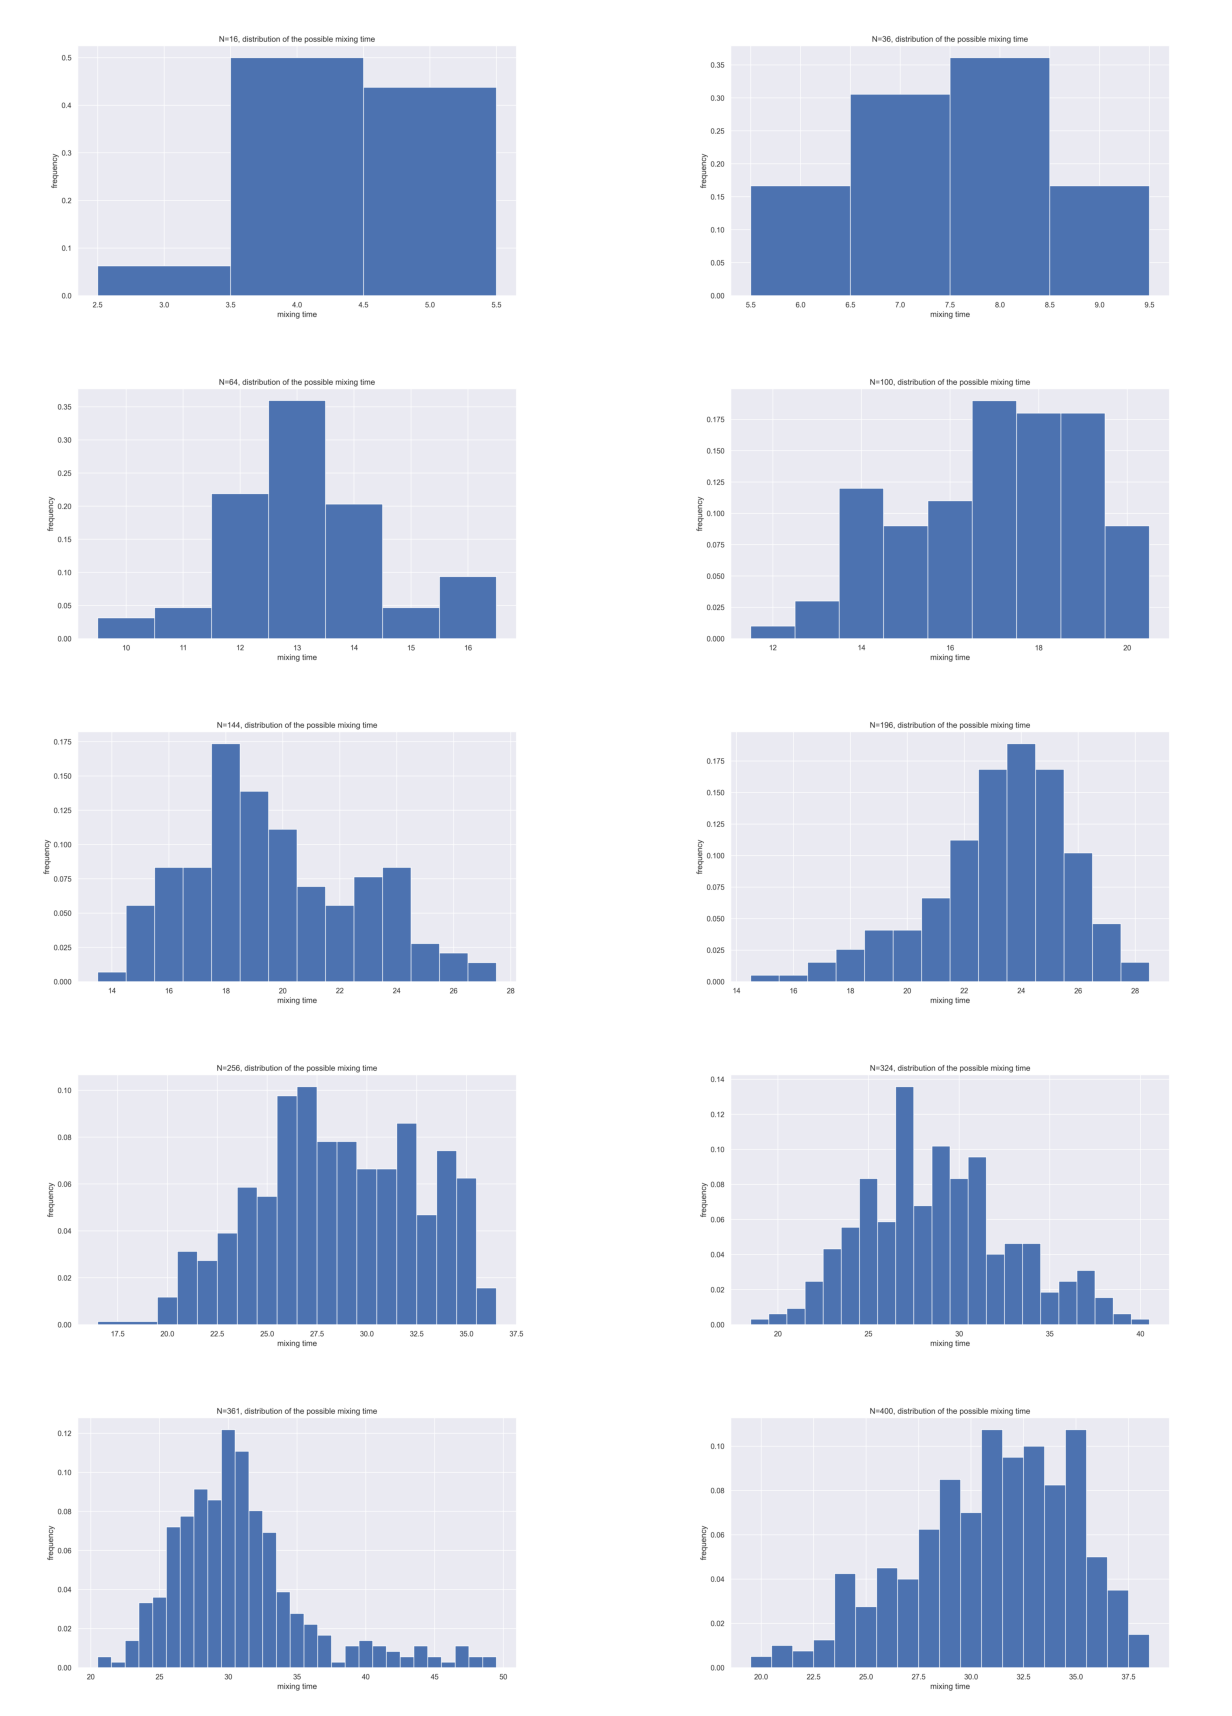

In [15]:
files=[]
for L in [4,6,8,10,12,14,16,18,19,20]:
    files.append("Plots_new/histogram_mixing_time_L={}_r=2_.png".format(L))

plt.figure(figsize=(20, 24))
for i, file_name in enumerate(files):
    plt.subplot(5, 2, i+1)
    plt.imshow(plt.imread(file_name))
    plt.axis('off')

plt.tight_layout()
plt.show()

The distribution of the possible mixing time that can be obtained does not have a defined structure when the number of nodes is increased, the variance increases but the mixing time cannot be deduced from the average value of the mixing time, i.e. the maximum value in the x axis. We therefore limited our analysis to a number of 400 nodes 


To calculate the mixing time we stored the paths for each starting node in a database, then we took the mixing time as an index, plus 1, of the total variance when it reaches a value below 0.25 

In [ ]:
# This code creates for each different starting node for the graphs with L=[2,..,16] (r=2) a lot of random walks

max_steps_vec=[10,15,20,30,40,50,50,50,50,55,60,60,70,70,80,80,90,90,100]
max_walks_vec=[]
for L in range(2,17):
    max_walks_vec.append(50*(L**2))
r=2
count=0
for L in tqdm(range(2,17)):
    max_steps=max_steps_vec[count]
    max_walks=max_walks_vec[count]
    count=count+1
    #input graph
    input_graph = open('Small_world_graphs/graph_L={}_r={}.pkl'.format(L,r), 'rb')
    G = pickle.load(input_graph)
    for starting in G:
        #input path
        paths=get_path_forG(G, L, max_steps=max_steps, max_walks=max_walks, start_node=v,
                                random_walk_function=lazy_2d_random_walk)
        output = open('Small_world_L={}_r={}/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,r,L,max_steps,
                                                                                 max_walks,starting), 'rb')
        pickle.dump(paths,output)
        output.close()
    input_graph.close()

In [ ]:
# This code computes the mixing time

max_steps_vec=[10,15,20,30,40,50,50,50,50,55,60,60,70,70,80,80,90,90,100]
max_walks_vec=[]
for L in range(2,21):
    max_walks_vec.append(50*(L**2))
r=2
mixing_time=[]
count=0
for L in tqdm(range(2,17)):
    max_steps=max_steps_vec[count]
    mixing_time_graph_start=[] # to store the mixing time for each different starting point in a given graph
    max_walks=max_walks_vec[count]
    count=count+1
    #input graph
    input_graph = open('Small_world_graphs/graph_L={}_r={}.pkl'.format(L,r), 'rb')
    G = pickle.load(input_graph)
    #start_path=start_path_2
    for starting in G:
        #input path
        path = open('Small_world_L={}_r={}/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,r,L,max_steps,
                                                                                 max_walks,starting), 'rb')
        data1 = pickle.load(path)
        norm_vector = get_L1_norm(G, L, data1, max_steps=max_steps, max_walks=max_walks)
        path.close()
        for variance in norm_vector:
            # when total variance is less than 0.25 we stop the for cycle and we fill
            # the mixing_time_graph list with the index+1 of the element in norm_vector
            if variance<0.25: 
                mixing_time_graph_start.append(list(norm_vector).index(variance)+1)
                break
    mixing_time.append(mixing_time_graph_start)
    input_graph.close()
output=open('vector_data/mix_time_for_each_start_L=16.pkl','wb')
pickle.dump(mixing_time,output)
output.close()


we want to fit the mixing time over the number of nodes $N=L^2$ with the result in the paper
\begin{equation}
T_{mix}=\begin{cases} \Theta(\log (n)) & r<2\\
O(log(n)^4) & r=2\\
n^{\Omega(1)} & r>2
\end{cases}
\end{equation}
In the paper they also said they belive that the correct answer for $r=2$ is $T_{mix}=O(\log(n)^2)$.

fitted function is f2(n)=  1.1125238569916671 *log(n)^2
fitted function is f3(n)=  0.20881216998700153 *log(n)^3
fitted function is f4(n)=  0.037791356182826495 *log(n)^4


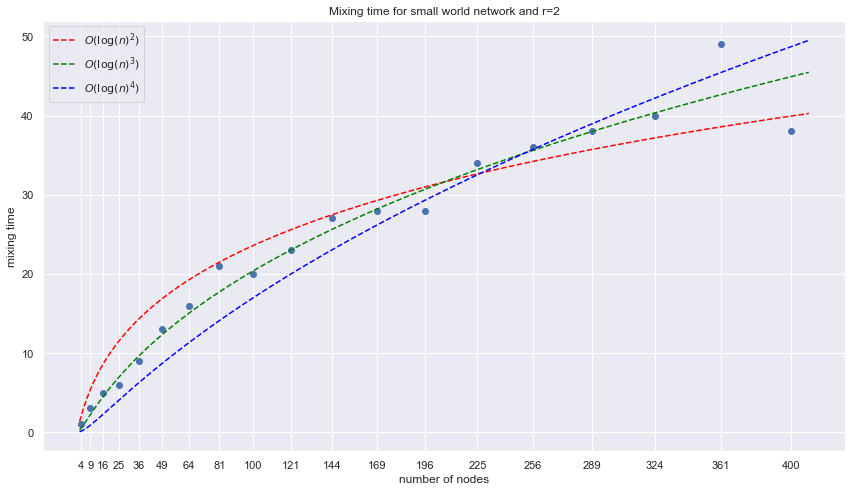

<Figure size 432x288 with 0 Axes>

In [17]:
# This code creates the plot

input_mix1=open('vector_data/mix_time_for_each_start_L=16.pkl','rb')
input_mix2=open('vector_data/mix_time_for_each_start_L=20.pkl','rb')
t1=pickle.load(input_mix1)
t2=pickle.load(input_mix2)
t1=np.array(t1)
t2=np.array(t2)



def func2(x, a):
    return a * np.log(x)**2
def func3(x, a):
    return a * np.log(x)**3
def func4(x, a):
    return a * np.log(x)**4

r=2
mixing_time=np.append(t1,t2,axis=0)
max_mixing_time=[]

#HERE WE TAKE THE MAX FOR THE POSSIBLE MIXING TIME
for i in range(0,len(mixing_time)):
    max_mixing_time.append(max(mixing_time[i]))
# filling the nodes list
nodes=[]
for L in range(2,21):
    nodes.append(L*L)

# popt is the parameter a
popt2, _ = optimize.curve_fit(func2, nodes, max_mixing_time)
popt3, _ = optimize.curve_fit(func3, nodes, max_mixing_time)
popt4, _ = optimize.curve_fit(func4, nodes, max_mixing_time)
poptexp, _ = optimize.curve_fit(exp, nodes, max_mixing_time)
#plot
fig1, ax1 = plt.subplots(figsize=(12,7))
x=np.linspace(3,410,num=10000)

ax1.scatter(nodes,max_mixing_time)
ax1.plot(x, func2(x, *popt2),'--', color='red', label="$O(\log(n)^2)$")
ax1.plot(x, func3(x, *popt3),'--', color='green', label="$O(\log(n)^3)$")
ax1.plot(x, func4(x, *popt4),'--', color='blue', label="$O(\log(n)^4)$")
#ax1.plot(x, exp(x, *poptexp),'--', color='black', label="$n^{\Omega(1)}$")
print('fitted function is f2(n)= ', popt2[0],'*log(n)^2')
print('fitted function is f3(n)= ', popt3[0],'*log(n)^3')
print('fitted function is f4(n)= ', popt4[0],'*log(n)^4')
#print('fitted function is exp(n)= ', poptexp[0],'*exp')
ax1.set_title('Mixing time for small world network and r=2')
ax1.set_xlabel('number of nodes')
ax1.set_ylabel('mixing time')
ax1.set_xticks(nodes)
#ax1.set_xticks(nodes)
ax1.legend()
plt.tight_layout()
plt.savefig(currentdir+'/Plots_new/'+'Mixing_time_large_for_r={}.png'.format(r), dpi=300)
plt.show()
plt.tight_layout()



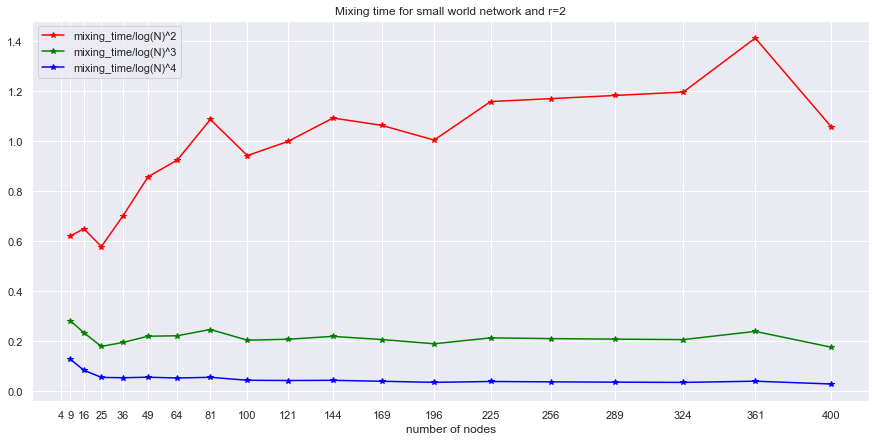

In [20]:
fig1, ax1 = plt.subplots(figsize=(15,7))
ax1.plot(nodes[1:],max_mixing_time[1:]/(np.log(nodes[1:])**2),"*-", color="red", label="mixing_time/log(N)^2")
ax1.plot(nodes[1:],max_mixing_time[1:]/(np.log(nodes[1:])**3),"*-", color="green", label="mixing_time/log(N)^3")
ax1.plot(nodes[1:],max_mixing_time[1:]/(np.log(nodes[1:])**4),"*-", color="blue", label="mixing_time/log(N)^4")
                                                                                                                       
                                                                                                           
ax1.set_title('Mixing time for small world network and r=2')
ax1.set_xlabel('number of nodes')
ax1.set_xticks(nodes)
ax1.legend()

### Mixing time for different r parameter

We compute the mixing time for r=[0.1,1,3,100] for N up to 100 nodes.

In [6]:
# Creation of the graphs
for r in tqdm([0.1,1,3,100]):
    for L in range(3,11):
        G=small_world_2d_new(L,r,seed=42)
        output = open("Small_world_graphs/graph_L={}_r={}.pkl".format(L,r),'wb')
        pickle.dump(G,output)
        output.close()

In [10]:
# computation of the mixing time, here we don't store in our database the paths
max_steps_vec=[10,15,20,25,30,35,45,50]
max_walks_vec=[]
for L in range(3,11):
    max_walks_vec.append(50*(L**2))

mixing_time=[]
for r in tqdm([0.1,1,3,100]):
    count = 0
    mixing_time_graph_r=[]
    for L in range(3,11):
        mixing_time_graph_start=[]
        max_walks=max_walks_vec[count]
        max_steps=max_steps_vec[count]
        input_graph = open("Small_world_graphs/graph_L={}_r={}.pkl".format(L,r),'rb')
        G = pickle.load(input_graph)
        for v in G:
            paths = get_path_forG(G,L, max_steps=max_steps, max_walks=max_walks, start_node=v,
                                random_walk_function=lazy_2d_random_walk)
            norm_vector = get_L1_norm(G,L,paths,max_steps,max_walks,regular_graph=False)
            for variance in norm_vector:
                if variance<0.25: 
                    mixing_time_graph_start.append(list(norm_vector).index(variance)+1)
                    break
        mixing_time_graph_r.append(max(mixing_time_graph_start))
        count = count+1
    mixing_time.append(mixing_time_graph_r)

# Store the mixing time vector
output = open("vector_data/different_r_mixing_time.pkl",'wb')
pickle.dump(mixing_time,output)
output.close()

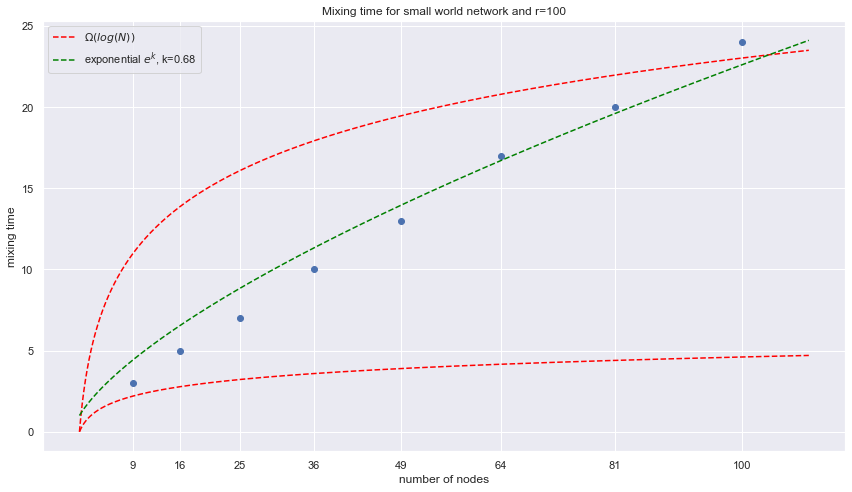

In [112]:
# This code creates the plot for r=100
def exp(x, a):
    return x**a 
def log(x,a):
    return a*np.log(x)
r=100
nodes=[]
for L in range(3,11):
    nodes.append(L*L)


input_mix = open("vector_data/different_r_mixing_time.pkl",'rb')
mixing_time_vec = pickle.load(input_mix)
mixing_time = mixing_time_vec[3]

popt2, _ = optimize.curve_fit(exp, nodes, mixing_time)
fig1, ax1 = plt.subplots(figsize=(12,7))
x=np.linspace(1,110,num=10000)
ax1.scatter(nodes,mixing_time)
ax1.plot(x, 1*np.log(x),"--",color="red", label="$\Omega(log(N))$")
ax1.plot(x, 5*np.log(x),"--",color="red")
ax1.plot(x, exp(x, *popt2),'--', color='green', label="exponential $e^k$, k={:.2f}".format(popt2[0]))
ax1.set_title('Mixing time for small world network and r={}'.format(r))
ax1.set_xlabel('number of nodes')
ax1.set_ylabel('mixing time')
ax1.set_xticks(nodes)
ax1.legend()
plt.tight_layout()
#plt.savefig(currentdir+'/Plots_new/'+'Mixing_time_r={}.png'.format(r), dpi=300)
plt.show()


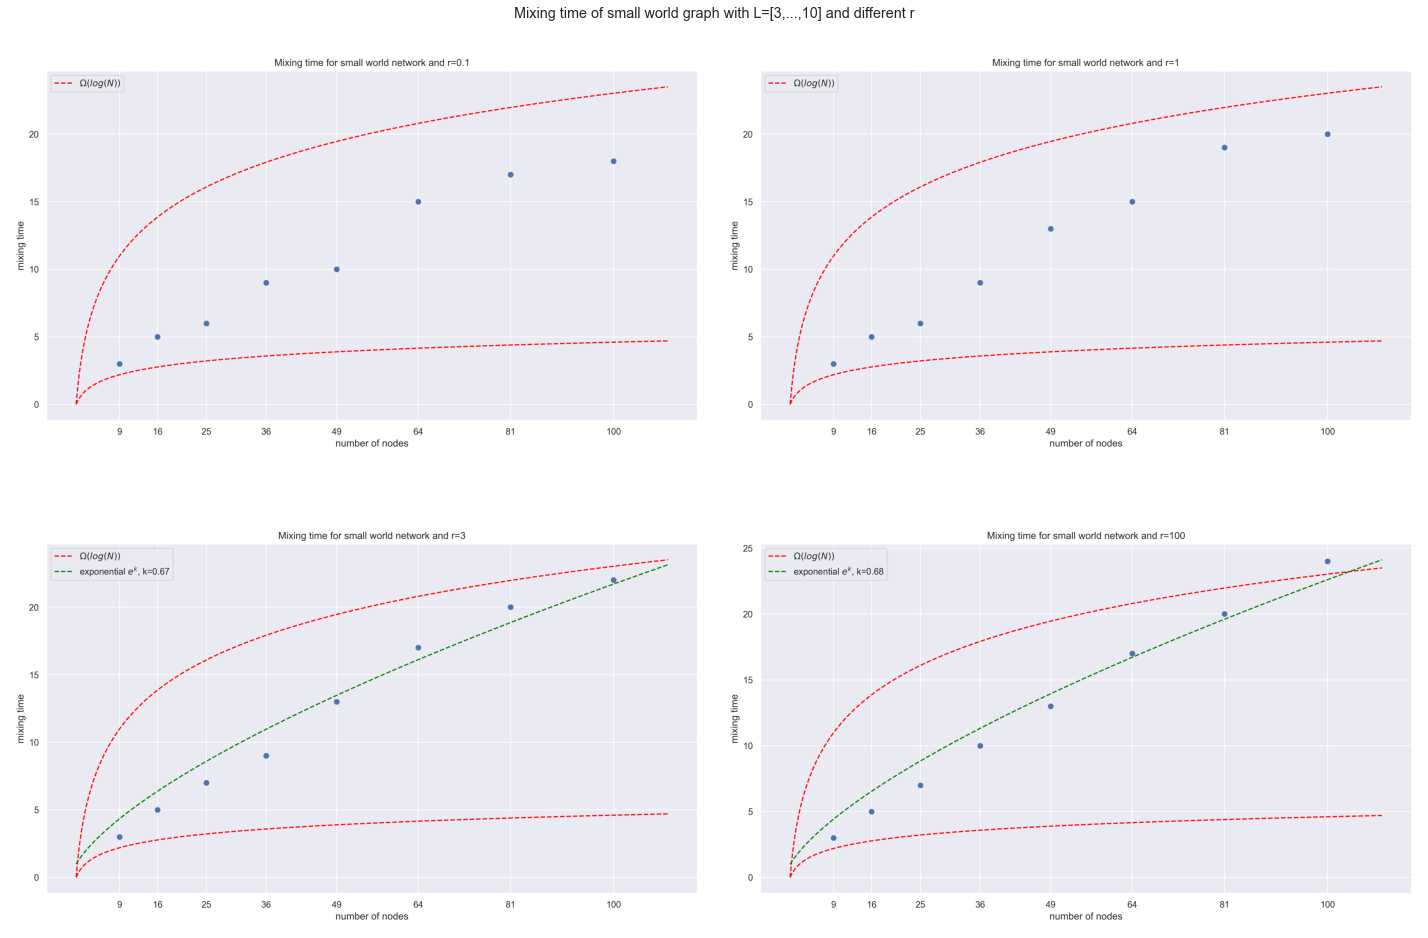

In [63]:
#COLLECTING THE DATA
files=[]
for r in [0.1,1,3,100]:
    files.append("Plots_new/Mixing_time_r={}.png".format(r))

plt.figure(figsize=(20, 14))
plt.suptitle('Mixing time of small world graph with L=[3,...,10] and different r')

for i, file_name in enumerate(files):
    plt.subplot(2, 2, i+1)
    plt.imshow(plt.imread(file_name))
    plt.axis('off')

plt.tight_layout()
plt.show()

We can see that for $r<2$ the behaviour the mixing_time is $\Omega(\log(N))$ (is bounded from above and below by a loghritmic function), but for r>2 this loghratim increase is broken. This is a clear consequence of the fact that the bigger $r$, the less long range edge there are. 

# comparison with the mixing time of a normal torus graph

we compute now the mixing time for a normal torus graph and lazy random walks. This is a simpler task, the graph is regular, hence we can study the random walk distribution only considering a single initial starting point.

In [83]:
# computation of the mixing time for normal 2d graph, here we don't store in our database the paths

max_steps=150
max_walks_vec=10000
mixing_time=[]
for L in tqdm(range(2,21)):
    G=nx.grid_2d_graph(L,L,periodic=True)
    start=(0,0)
    paths = get_path_forG(G,L, max_steps=max_steps, max_walks=max_walks, start_node=start,
                                random_walk_function=lazy_2d_random_walk)
    norm_vector = get_L1_norm(G,L,paths,max_steps,max_walks,regular_graph=True)
    for variance in norm_vector:
        if variance<0.25: 
            mixing_time.append(list(norm_vector).index(variance)+1)
            break

# Store the mixing time vector
output = open("vector_data/torus_graph_mixing_time.pkl",'wb')
pickle.dump(mixing_time,output)
output.close()

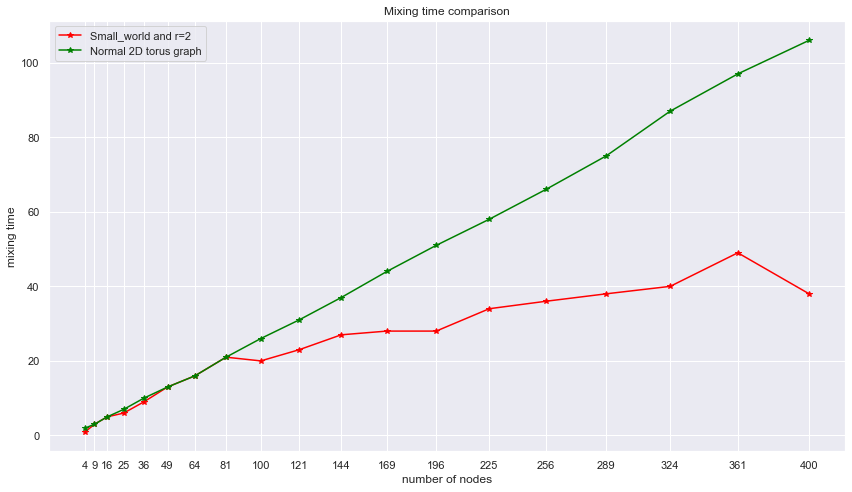

In [87]:
# Plot

input_mix1=open('vector_data/mix_time_for_each_start_L=16.pkl','rb')
input_mix2=open('vector_data/mix_time_for_each_start_L=20.pkl','rb')
t1=pickle.load(input_mix1)
t2=pickle.load(input_mix2)
t1=np.array(t1)
t2=np.array(t2)
mixing_time_small_world_vec=[]
mixing_time_small_world_vec=np.append(t1,t2,axis=0)
mixing_time_small_world=[]
for i in range(0,len(mixing_time_small_world_vec)):
    mixing_time_small_world.append(max(mixing_time_small_world_vec[i]))

input_mix = open("vector_data/torus_graph_mixing_time.pkl",'rb')
mixing_time_normal=pickle.load(input_mix)

nodes=[]
for L in range(2,21):
    nodes.append(L**2)

fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.plot(nodes, mixing_time_small_world,"*-",color="red", label="Small_world and r=2")
ax1.plot(nodes, mixing_time_normal,"*-",color="green", label="Normal 2D torus graph")
ax1.set_title('Mixing time comparison'.format(r))
ax1.set_xlabel('number of nodes')
ax1.set_ylabel('mixing time')
ax1.legend()
ax1.set_xticks(nodes)
plt.savefig(currentdir+'/Plots_new/'+'Mixing_time_comparison.png'.format(r), dpi=300)
plt.tight_layout()

# Phase Transition

For a fixed number of nodes (we use here L=10 namely 100 nodes), if we plot the mixing time agains the r parameter we should observe a variation in the behaviour of the mixing time line at r=2

In [89]:

# computation of the mixing time, here we don't store in our database the paths
max_walks=5000
max_steps=30
L=10
mixing_time_r=[]
for r in tqdm([0.001,0.1,0.4,0.7,1.0,1.3,1.6,2.0,2.3,2.6,2.9,3.2,3.5,3.8,4.0,100]):
    G = small_world_2d_new(L,r,seed=42)
    mixing_time_graph_start=[]
    for v in G:
        paths = get_path_forG(G,L, max_steps=max_steps, max_walks=max_walks, start_node=v,
                            random_walk_function=lazy_2d_random_walk)
        norm_vector = get_L1_norm(G,L,paths,max_steps,max_walks,regular_graph=False)
        for variance in norm_vector:
            if variance<0.25: 
                mixing_time_graph_start.append(list(norm_vector).index(variance)+1)
                break
    mixing_time_r.append(max(mixing_time_graph_start))
    count = count+1

# Store the mixing time vector
output = open("vector_data/different_r_same_L=10_mixing_time.pkl",'wb')
pickle.dump(mixing_time_r,output)
output.close()

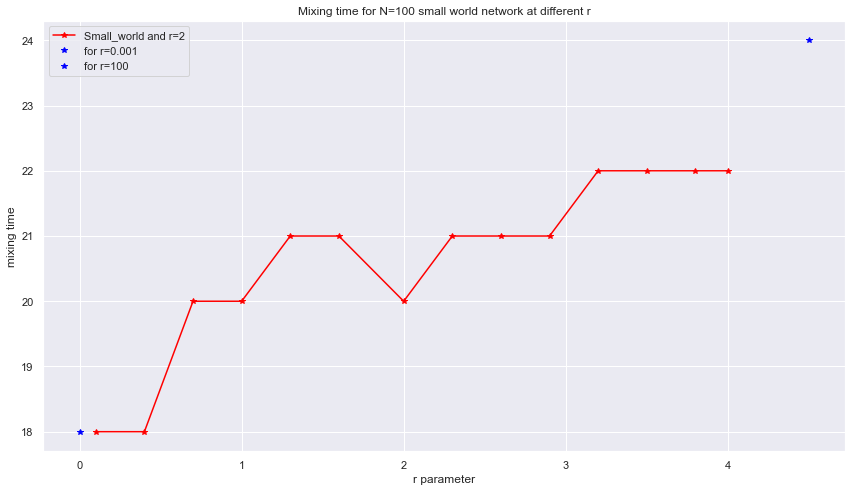

In [107]:
input_mix=open("vector_data/different_r_same_L=10_mixing_time.pkl",'rb')
mixing_time=pickle.load(input_mix)
r_vec=[0.1,0.4,0.7,1.0,1.3,1.6,2.0,2.3,2.6,2.9,3.2,3.5,3.8,4.0]
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.plot(r_vec, mixing_time[1:-1],"*-",color="red", label="Small_world and r=2")
ax1.plot(0, mixing_time[0],"*",color="blue", label="for r=0.001")
ax1.plot(4.5, mixing_time[-1],"*",color="blue", label="for r=100")
ax1.set_title('Mixing time for N=100 small world network at different r')
ax1.set_xlabel('r parameter')
ax1.set_ylabel('mixing time')
ax1.legend()
plt.savefig(currentdir+'/Plots_new/'+'Mixing_time_for_L=10_different_r.png', dpi=300)
plt.tight_layout()